# HOMOLOGOUS COLLAPSE OF AN HOMOGENEOUS SPHERE

$$\ddot{r}=-\frac{Gm(r)}{r^2}$$

$$\dot{r}\ddot{r}=-\frac{Gm(r)}{r^2}\dot{r}$$

$$\int_{0}^t \dot{r}\ddot{r} dt = -Gm(r_0)\int_{0}^t \frac{\dot{r}}{r^2} dt$$

HOMOLOGOUS COLLAPSE: $m(r(t))=m(r_0)$ at every $t$. 

$$\frac{1}{2}\dot{r(t)}^2=Gm(r_0)\left(\frac{1}{r(t)}-\frac{1}{r_0}\right)$$

$$K(t)=Gm_{star}\frac{4\pi}{3}\rho r_0^3\left(\frac{1}{r(t)}-\frac{1}{r_0}\right)$$

Given initial $r_0$, what is $r(t)$ during the homologous collapse? Integrating $\dot{r(t)}$:


$$-\sqrt{r_0}\left( \sqrt{r(t)(r_0-r(t))}+r_0\arccos{\sqrt{\frac{r(t)}{r_0}}}\right)=-\sqrt{\frac{8\pi}{3}\rho r_0^3} t$$ holds for $t<t_{free fall}=\sqrt{\frac{3\pi}{32G\rho}}$, $r(t)<r_0 \forall t$

The equation is not analytical: it has to be solved numerically. Define function f:

$$f_{r_0,t}(r)=-\sqrt{r_0}\left( \sqrt{r(r_0-r)}+r_0\arccos{\sqrt{\frac{r}{r_0}}}\right)+\sqrt{\frac{8\pi}{3}\rho r_0^3} t$$

At every $t$, and for every $r_0$, $r(t)$ is found with bisection method: extremes of integration are $10^{-6}$ (function not defined in 0) and $r_0$ (NOT R!) 


**GENERATING AN HOMOGENEUS SPHERE**

$$dV = (r^2 dr)(\sin\theta d\theta)(d \phi)$$

$$p(r) = \frac{1}{M} 4 \pi r^2 \rho_0 $$

$$P(r) =  \int_0^r p(r) dr = \frac{4\pi \rho_0}{3M} r^3   $$
 
$$\int_0^R p(r) dr = 1$$

$$r(P) = \left(\frac{3MP}{4\pi \rho_0}\right)^{1/3}$$

$$p(\theta) = \frac{\sin\theta}{2}$$

$$P(\theta) = \int_0^\theta p(\theta) = \frac{-\cos\theta+1}{2}$$

$$\theta(P)=\arccos(1-2P)$$

$$\int_0^\pi p(\theta) = 1$$

$$p(\phi) = \frac{1}{2\pi}$$

$$P(\phi) = \frac{\phi}{2\pi}$$

$$\phi(P) = 2\pi P $$

**TREE-CODE**

This algorithm does an approximation on the force computation. 
Given N particles in a volume V, tree-code devides teh volume iteratively into cubes up to the point each one contains only 1 particle. 
When the force acting over one particle i is computed, particles sufficiently far away from it are grouped in one point (the center ??) and their mass is sum up in total mass M. This is equal to take only the first order of the multipolar expansion (monopole term).

Computational cost: $N\log(N)$

Leaf opening criterion: $\theta = r_{cell}/d < \theta_{crit}$ 

$\theta_{crit}$ is the accuracy parameter (<<1 radiant)

Gravitational softening: to avoid huge scatterings we set the force different from newtonian one if the particles get to much close:

$|f_{ij}|=\frac{Gm_im_j}{|r_i-r_j|^2+\epsilon^2}$

does not diverge: it's like the mass of each particle has been smoothed over a finite volume.

Time integration: LEAP-FROG method. $t_i -> t_{i+1}$

$v_{i+\frac{1}{2}}=v_i+(\frac{h}{2})a_i$

$r_{i+1}=r_i+hv_{i+\frac{1}{2}}$

$v_{i+1}=v_{i+\frac{1}{2}}+(\frac{h}{2})a_i$

h is NOT ADAPTIVE, it's set at imput. We will set $h<<t_{dyn}$

$\epsilon = 10^{-4}(V/N)^{1/3}$

**INTERNAL UNITS**

nbody_sh1 works with internal units. $G_{iu}$ is set equal to 1. We are free to express masses and distances in arbitrary units, as far as velocities and times are consistent. In order to see that, notice that $\frac{GM}{rv^2}$ is adimensional. 

$$\frac{M_{iu}}{r_{iu}v_{iu}^2}=\frac{G_{cgs}M_{cgs}}{r_{cgs}v_{cgs}^2}$$

Velocities in internal units will be related to physical velocities by:

$$v_{iu}=\sqrt{\frac{r_{cgs}}{G_{cgs}M_{cgs}}}v_{cgs}$$

We need to tranform time units in internal units as well. $\frac{rt}{v}$ is adimensional. 

$$\frac{t_{iu}v_{iu}}{r_{iu}}=\frac{t_{cgs}v_{cgs}}{r_{cgs}}$$

$$t_{iu}=\frac{r_{iu}}{r_{cgs}}\sqrt{\frac{r_{cgs}}{G_{cgs}M_{cgs}}}t_{cgs}$$

In [1]:
from myTreecode import Star
from myTreecode import Tree
from myTreecode import grav_force_star_node
from myTreecode import evolve
from view import view
from view import show_animation
from view import sky_projection

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random

In [2]:
### constants and internal units ###

c_cgs = 2.99792458 * 10**10 #cm/s
G_cgs = 6.67259 * 10**-8 #G in cgs
M_sun = 1.9891 * 10**33 #solar mass in g
R_sun = 6.9598 * 10**10 #solar radius in cm 
M_earth = 5.976 * 10**27 #earth mass in g
R_earth = 6.378 * 10**8 #earth radius in cm
ly = 9.463 * 10**17 #light year in cm
parsec = 3.086 * 10**18 #parsec in cm
AU = 1.496 * 10**13 #astronomical unit in cm
Sun_shw = 2*G_cgs*M_sun/(c_cgs**2) #Sun's Schwarschild radius in cgs

kB = 1.380649 * 10**-16 #erg/K

def v_IU(M_cgs, r_cgs, v_cgs):
    return np.sqrt(r_cgs/(G_cgs*M_cgs))*v_cgs

def c_IU(M_cgs, r_cgs):
    return np.sqrt(r_cgs/(G_cgs*M_cgs))*c_cgs

def t_IU(M_cgs, r_cgs, t_cgs):
    return t_cgs/(np.sqrt(r_cgs/(G_cgs*M_cgs))*r_cgs)

print("If we choose 1 solar mass as mass unit and 1 parsec unit as distance unit:")
print("1 Myr expressed in internal units is: %f" % (t_IU(M_sun,parsec,3.156*10**13)))
print("1 s expressed in internal units is: %e" % (t_IU(M_sun,parsec,1)))
print("1 time unit is: %f Myrs" % (1/t_IU(M_sun,parsec,3.156*10**13)))
print("1 time unit is: %f s" % (1/t_IU(M_sun,parsec,1)))
print("Light speed expressed in internal units is: %E" % (c_IU(M_sun,parsec)))
print("Sun rest mass energy in internal units is: %E" %(1*c_IU(M_sun,parsec)))
print("Sun kinetic energy (0.5M(200km/s) = %E erg) in internal units is: %E" %(0.5*M_sun*(200*10**5)**2, 0.5*v_IU(M_sun, parsec, 200*10**5)))
print("1 km/s in internal units is: %f" %(v_IU(M_sun, parsec, 1*10**5)))

time_conversion_factor = 14.910128      # 1 IU in Myrs
energy_conversion_factor = 1/1524.834   # sun kinetic energy in internal units
velocity_conversion_factor = 1 / 15.248335  # 1 IU in Km/s 
time_conversion_factor_s = 470563626066861.375000 # 1 IU in s


If we choose 1 solar mass as mass unit and 1 parsec unit as distance unit:
1 Myr expressed in internal units is: 0.067069
1 s expressed in internal units is: 2.125111e-15
1 time unit is: 14.910128 Myrs
1 time unit is: 470563626066861.375000 s
Light speed expressed in internal units is: 4.571336E+06
Sun rest mass energy in internal units is: 4.571336E+06
Sun kinetic energy (0.5M(200km/s) = 3.978200E+47 erg) in internal units is: 1.524834E+03
1 km/s in internal units is: 15.248335


In [3]:
class Homogeneous_Sphere:
    
    def __init__(self,N,rho,m=1,Omega=0):
        self.N = int(N) 
        self.m = m
        self.M = self.N * self.m
        self.rho = rho
        self.R = (3 * self.M / (4*np.pi*self.rho))**(1/3)
        self.Omega = Omega # angular velocity of the solid sphere

        self.free_fall_time = np.sqrt(3*np.pi/(32*self.rho))
 
        print(f"Homogeneous sphere of {self.N} stars and total mass {self.M:.2f} solar masses, density is {self.rho:.2f} solar masses/pc^3. Radius is {self.R:.2f} pc."
              f"Free fall time is {self.free_fall_time:.1e} in internal units { self.free_fall_time*time_conversion_factor:.1e} Myrs.")

        # initialize system
        
        self.t = [0]
        self.system = []

        initial_conditions = []
        
        for i in range(self.N):
            
            u = random.uniform(0,1)
            v = random.uniform(0,1)
            w = random.uniform(0,1)
            r = (3*self.M * u / (4*np.pi*self.rho))**(1/3)
            theta = np.arccos(1-2*v) 
            phi = 2*np.pi*w
            
            x = np.array([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])
            v = np.array([0,0,0])  # points initially with zero radial velocity, tangential velocity given by angular momentum (solid sphere)
            
            initial_conditions.append(Star(self.m, x, v))
            
        self.system.append(np.array(initial_conditions))


In [4]:
hom = Homogeneous_Sphere(N=300,rho=1)

Homogeneous sphere of 300 stars and total mass 300.00 solar masses, density is 1.00 solar masses/pc^3. Radius is 4.15 pc.Free fall time is 5.4e-01 in internal units 8.1e+00 Myrs.


In [10]:
#print([star.v_magn for star in hom.system[1]])

In [6]:
evolve(hom,tstop = 1,dt = 0.01,dtout=0.1,eps=0.001,orbit_indexes=[20,60,70,90,1])

Evolving system:   0%|          | 0/1 [00:00<?, ?it/s]

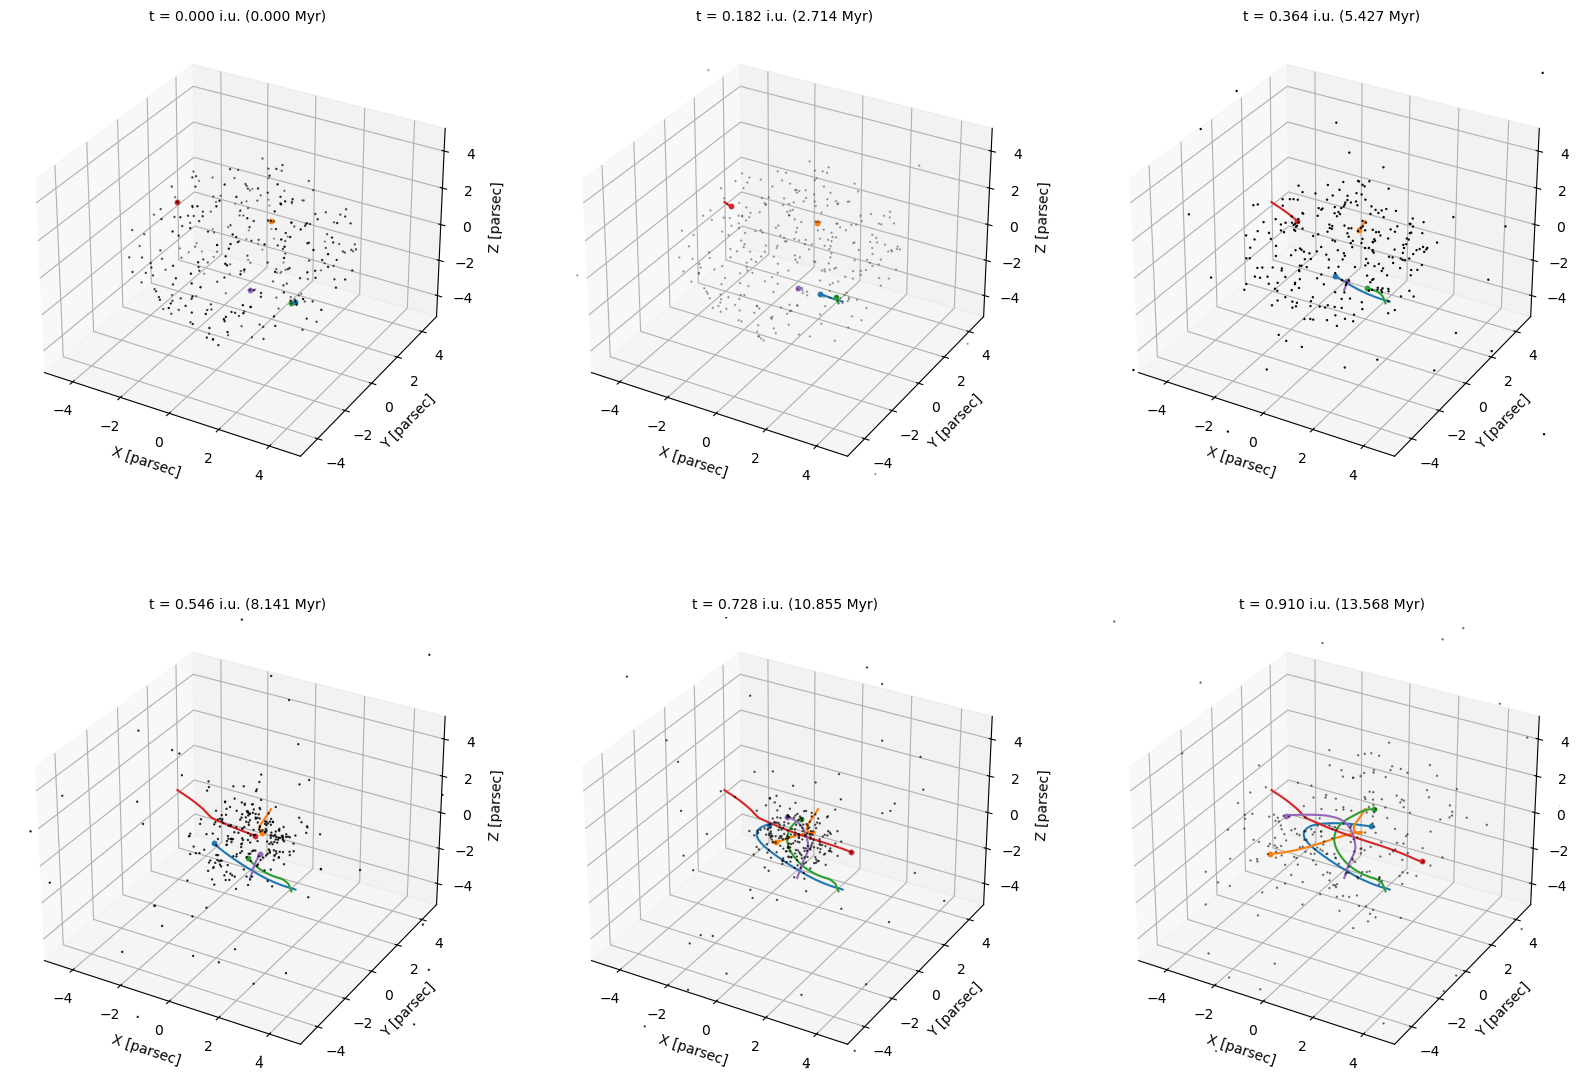

In [11]:
view(hom,r_max=5,t=np.linspace(hom.t[0],hom.t[-1],6))

In [51]:
show_animation(hom,r_max= 5,speed=1)

In [33]:
import scipy

def DF_collapse(galaxy,t=[0]): # distribution function
    n_rows = (len(t) + 3 - 1) // 3
    fig, ax = plt.subplots(n_rows, 3, figsize=(20, 7 * n_rows))
    ax = ax.flatten()

    # function for plotting analytic curve
    r_initial = np.linspace(10**-5,galaxy.R,100) #starting point can't be 0. Function f is not defined in 0
    f = lambda rt, r_initial, t : -np.sqrt(r_initial)*(np.sqrt(rt*(r_initial-rt))+r_initial*np.arccos(np.sqrt(rt/r_initial)))+np.sqrt(8*np.pi*galaxy.rho*r_initial**3 / 3)*t   
    
    for i, time in enumerate(t):
    
        if time > galaxy.t[-1]: 
            time = galaxy.t[-1] 
        frame_t = np.digitize(time, galaxy.t) - 1

        radii = np.array([star.r for star in galaxy.system[frame_t]])
        velocities = np.array([star.v_magn for star in galaxy.system[frame_t]]) * velocity_conversion_factor # in km/s
    
        r_lim = np.quantile(radii,0.9)
        v_lim = np.quantile(velocities,0.9)
        bins = [np.linspace(0, r_lim, 50), np.linspace(0, v_lim, 50)]
        ax[i].hist2d(radii, velocities, bins=bins)

        ax[i].set_title(f"t = {time:.3f} i.u. ({time * time_conversion_factor:.3f} Myr)", fontsize=10)
        ax[i].set_xlabel('r [pc]')
        ax[i].set_ylabel('v [km/s]')    
            
        if time < galaxy.free_fall_time:
                    
            r_of_t = []
            for r0 in r_initial:
                r_of_t.append(scipy.optimize.bisect(f, 10**-7, r0, args=(r0, time), xtol=2e-12, rtol=8.881784197001252e-16, maxiter=100, full_output=False, disp=True))
            r_of_t = np.array(r_of_t)
            
            K = 4*np.pi * galaxy.rho * r_initial**3 /3 * (1/r_of_t - 1/r_initial)
            v_of_r = np.sqrt(2*K) * velocity_conversion_factor
                
            ax[i].plot(r_initial,v_of_r, linewidth=2, c="r") #, label = "kinetic energy") 
    

In [34]:
print(hom.t)

[0, 0.10999999999999999, 0.21000000000000005, 0.3100000000000001, 0.4100000000000002, 0.5100000000000002, 0.6100000000000003, 0.7100000000000004, 0.8100000000000005, 0.9100000000000006]


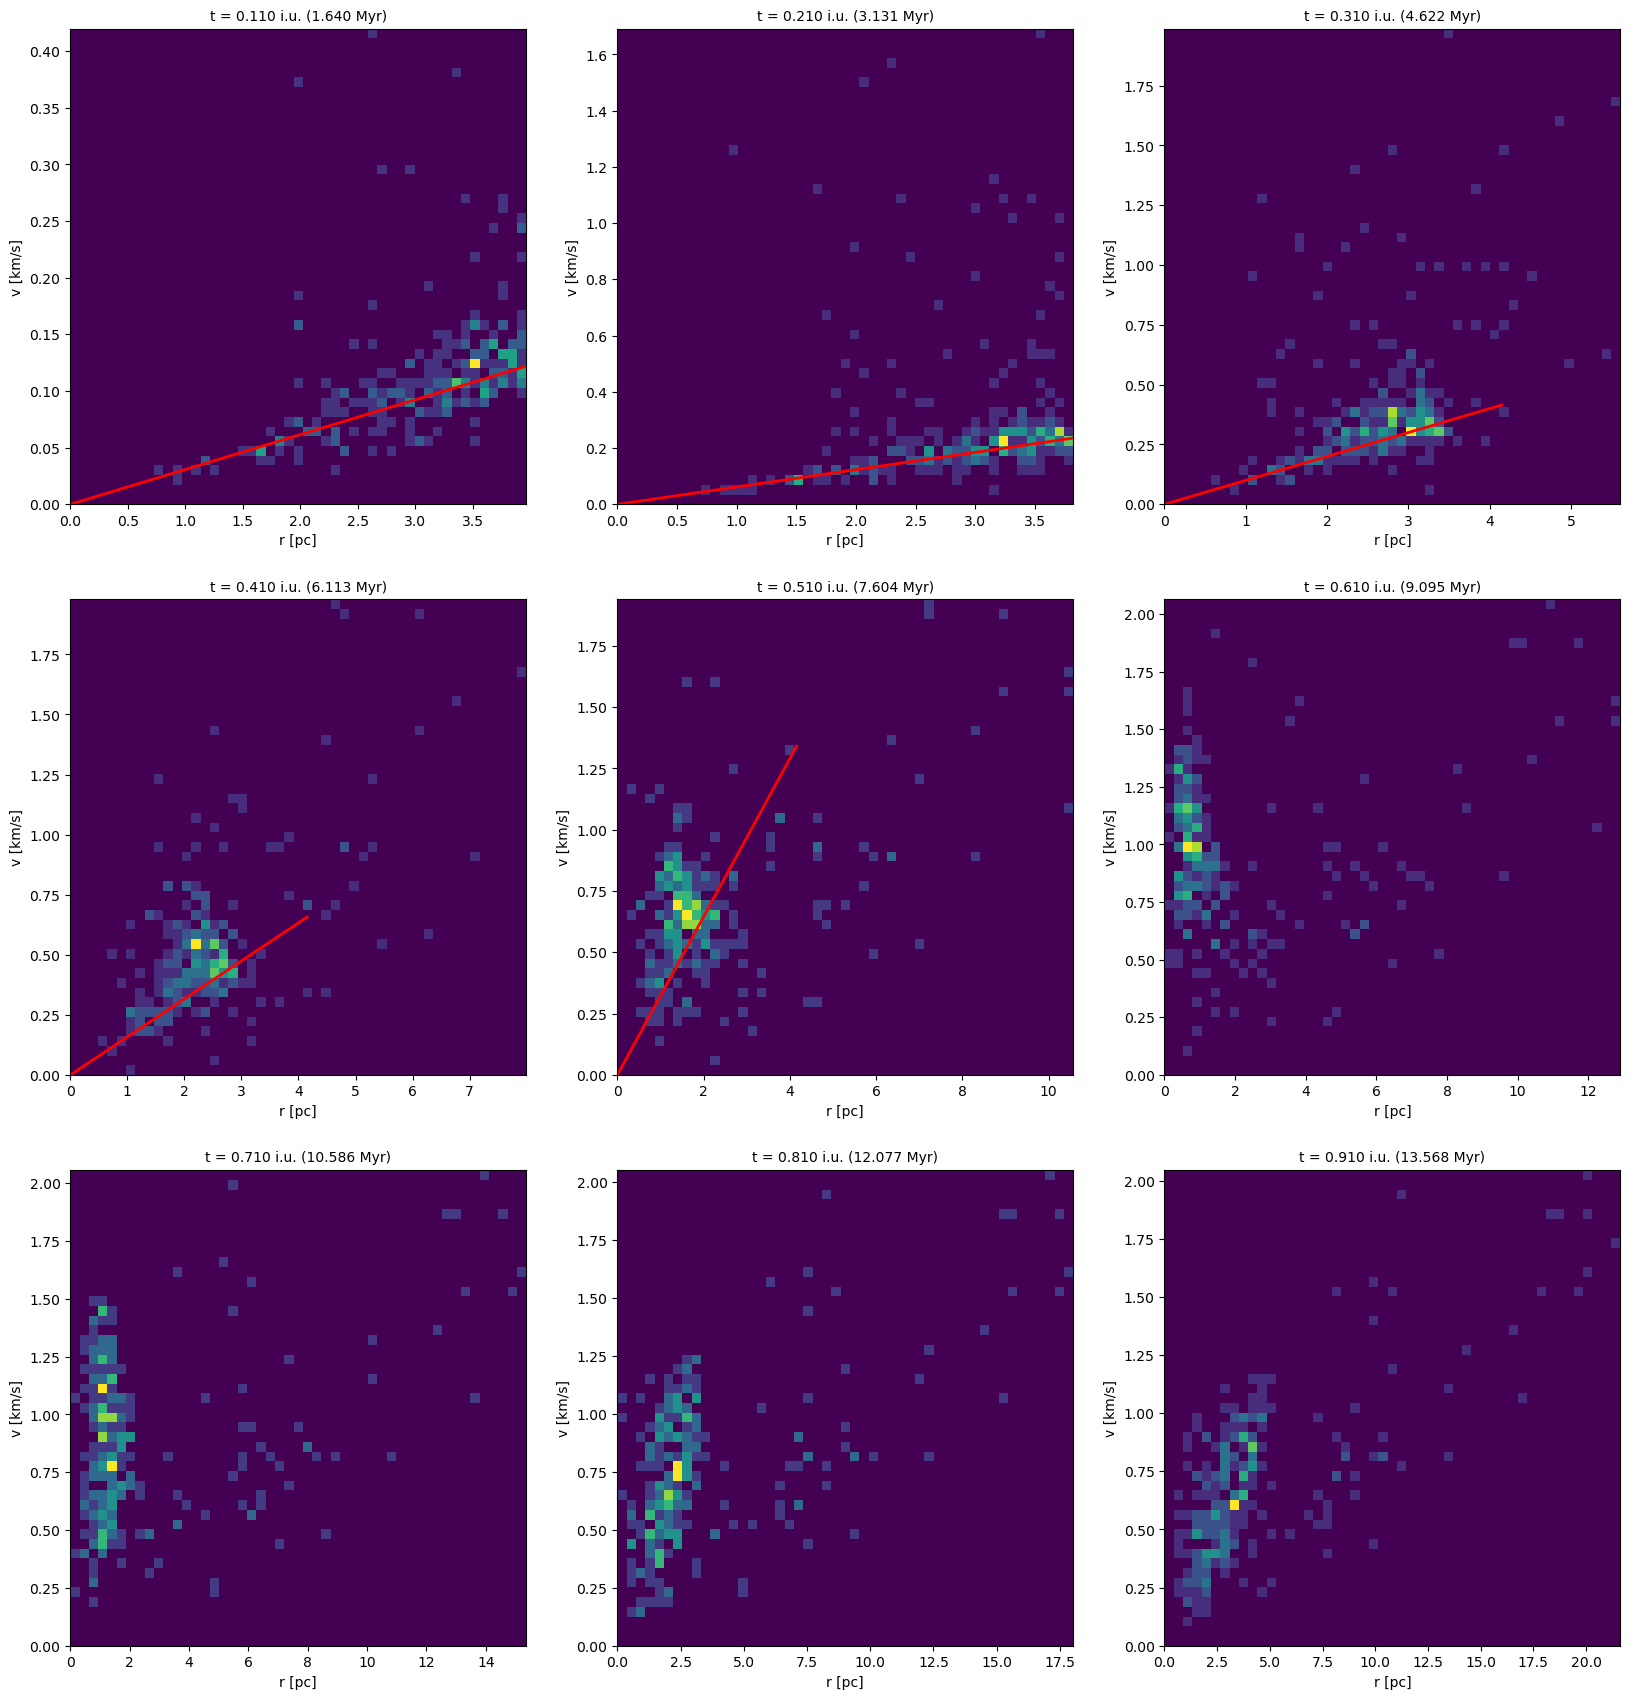

In [35]:
DF_collapse(hom,t=np.linspace(hom.t[1],hom.t[-1],(len(hom.t)-1)))

In [49]:
from matplotlib import animation
from IPython.display import HTML

def DF_collapse_animation(galaxy):
    fig, ax = plt.subplots()
    ax.set_xlabel('r [pc]')
    ax.set_ylabel('v [km/s]')

    r_initial = np.linspace(10**-5, galaxy.R, 100)
    f = lambda rt, r_initial, t : -np.sqrt(r_initial)*(np.sqrt(rt*(r_initial-rt))+r_initial*np.arccos(np.sqrt(rt/r_initial)))+np.sqrt(8*np.pi*galaxy.rho*r_initial**3 / 3)*t   

    def update(frame):
        time = galaxy.t[frame]

        radii = np.array([star.r for star in galaxy.system[frame]])
        velocities = np.array([star.v_magn for star in galaxy.system[frame]]) * velocity_conversion_factor
        
        ax.clear()

        r_lim = np.quantile(radii, 0.9)
        v_lim = np.quantile(velocities, 0.9)
        bins = [np.linspace(0, r_lim, 50), np.linspace(0, v_lim, 50)]

        
        ax.hist2d(radii, velocities, bins=bins)
        ax.set_title(f"t = {time:.3f} i.u. ({time * time_conversion_factor:.3f} Myr)", fontsize=10)


        if time < galaxy.free_fall_time:
            r_of_t = []
            for r0 in r_initial:
                r_of_t.append(scipy.optimize.bisect(f, 10**-7, r0, args=(r0, time), xtol=2e-12, rtol=8.881784197001252e-16, maxiter=100, full_output=False, disp=True))
            r_of_t = np.array(r_of_t)

            K = 4 * np.pi * galaxy.rho * r_initial**3 / 3 * (1 / r_of_t - 1 / r_initial)
                
            v_of_r = np.sqrt(2 * K) * velocity_conversion_factor
            ax.plot(r_initial, v_of_r, linewidth=2, c='r')

    anim = animation.FuncAnimation(fig, update, frames=len(galaxy.t), interval=200, repeat=False)
    display(HTML(anim.to_jshtml()))
    plt.close()
    

In [50]:
DF_collapse_animation(hom)

/tmp/ipykernel_20103/1254648627.py:25: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.hist2d(radii, velocities, bins=bins)
